U-Net Model for Brain MRI Segmentation

In [ ]:
#Necessary Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models


c:\Users\rithv\GitHub\brain-mri-scans\code\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Load and Preprocess Image and Mask Data

<div style="font-size:85%">
  
1. Set paths for images and masks folders.  
2. Read the labels CSV file.  
3. Initialize lists for images and masks.  
4. Loop over each row:  
   1. Get filename and construct mask name.  
   2. Load image and mask in grayscale.  
   3. Resize to 64x64 and normalize to [0,1].  
   4. Append to lists.  
5. Convert to NumPy arrays with channel dimension.  
6. Print shapes.  

</div>

In [11]:
image_folder = "C:/Users/rithv/GitHub/brain-mri-scans/code/images/"
mask_folder  = "C:/Users/rithv/GitHub/brain-mri-scans/code/masks/"

df = pd.read_csv("labels.csv")   # filename,target

X = []
Y = []

for _, row in df.iterrows():
    filename = str(row["filename"])      # e.g., "1.png"
    base = filename.replace(".png", "")  # → "1"
    maskname = base + "_mask.png"        # → "1_mask.png"

    img_path  = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, maskname)

    img  = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("Missing image:", img_path)
        continue
    if mask is None:
        print("Missing mask:", mask_path)
        continue

    img  = cv2.resize(img, (64, 64)) / 255.0
    mask = cv2.resize(mask, (64, 64)) / 255.0

    X.append(img)
    Y.append(mask)

X = np.array(X)[..., np.newaxis]
Y = np.array(Y)[..., np.newaxis]

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (300, 64, 64, 1)
Y shape: (300, 64, 64, 1)


Define U-Net Model Function

<div style="font-size:85%">
  
1. Define a function to build the U-Net model.  
2. Create input layer.  
3. Build encoder with convolutional blocks and max pooling.  
4. Build bottleneck with convolutional layers.  
5. Build decoder with upsampling, concatenation, and convolutional blocks.  
6. Create output layer with sigmoid activation.  
7. Return the model.  

</div>

In [12]:
def unet_with_names(input_shape=(64, 64, 1)):
    inputs = layers.Input(shape=input_shape, name="input")

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same", name="enc_block1_conv1")(inputs)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same", name="enc_block1_conv2")(c1)
    p1 = layers.MaxPooling2D(name="enc_block1_pool")(c1)

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same", name="enc_block2_conv1")(p1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same", name="enc_block2_conv2")(c2)
    p2 = layers.MaxPooling2D(name="enc_block2_pool")(c2)

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same", name="enc_block3_conv1")(p2)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same", name="enc_block3_conv2")(c3)
    p3 = layers.MaxPooling2D(name="enc_block3_pool")(c3)

    # Bottleneck
    b = layers.Conv2D(256, 3, activation="relu", padding="same", name="bottleneck_conv1")(p3)
    b = layers.Conv2D(256, 3, activation="relu", padding="same", name="bottleneck_conv2")(b)

    # Decoder
    u3 = layers.UpSampling2D(name="dec_block3_up")(b)
    u3 = layers.Concatenate(name="dec_block3_concat")([u3, c3])
    c4 = layers.Conv2D(128, 3, activation="relu", padding="same", name="dec_block3_conv1")(u3)
    c4 = layers.Conv2D(128, 3, activation="relu", padding="same", name="dec_block3_conv2")(c4)

    u2 = layers.UpSampling2D(name="dec_block2_up")(c4)
    u2 = layers.Concatenate(name="dec_block2_concat")([u2, c2])
    c5 = layers.Conv2D(64, 3, activation="relu", padding="same", name="dec_block2_conv1")(u2)
    c5 = layers.Conv2D(64, 3, activation="relu", padding="same", name="dec_block2_conv2")(c5)

    u1 = layers.UpSampling2D(name="dec_block1_up")(c5)
    u1 = layers.Concatenate(name="dec_block1_concat")([u1, c1])
    c6 = layers.Conv2D(32, 3, activation="relu", padding="same", name="dec_block1_conv1")(u1)
    c6 = layers.Conv2D(32, 3, activation="relu", padding="same", name="dec_block1_conv2")(c6)

    outputs = layers.Conv2D(1, 1, activation="sigmoid", name="output_mask")(c6)

    return models.Model(inputs, outputs)


Define Dice Coefficient Function

<div style="font-size:85%">
  
1. Define a function to calculate the Dice coefficient.  
2. Flatten true and predicted labels.  
3. Compute intersection and sums.  
4. Return the Dice coefficient with smoothing.  

</div>

In [13]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


Define Dice Loss Function

<div style="font-size:85%">
  
1. Define a function to calculate the Dice loss.  
2. Return 1 minus the Dice coefficient.  

</div>

In [14]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

Compile the U-Net Model

<div style="font-size:85%">
  
1. Instantiate the U-Net model.  
2. Compile with Adam optimizer, Dice loss, and Dice coefficient metric.  
3. Print model summary.  

</div>

In [15]:
model = unet_with_names()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=[dice_coef]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 64, 64, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block1_conv1    │ (None, 64, 64,    │        320 │ input[0][0]       │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block1_conv2    │ (None, 64, 64,    │      9,248 │ enc_block1_conv1… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block1_pool     │ (None, 32, 32,    │          0 │ enc_block1_conv2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block2_conv1    │ (None, 32, 32,    │     18,496 │ enc_block1_pool[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block2_conv2    │ (None, 32, 32,    │     36,928 │ enc_block2_conv1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block2_pool     │ (None, 16, 16,    │          0 │ enc_block2_conv2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block3_conv1    │ (None, 16, 16,    │     73,856 │ enc_block2_pool[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block3_conv2    │ (None, 16, 16,    │    147,584 │ enc_block3_conv1… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_block3_pool     │ (None, 8, 8, 128) │          0 │ enc_block3_conv2… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_conv1    │ (None, 8, 8, 256) │    295,168 │ enc_block3_pool[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck_conv2    │ (None, 8, 8, 256) │    590,080 │ bottleneck_conv1… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_block3_up       │ (None, 16, 16,    │          0 │ bottleneck_conv2… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_block3_concat   │ (None, 16, 16,    │          0 │ dec_block3_up[0]… │
│ (Concatenate)       │ 384)              │            │ enc_block3_conv2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_block3_conv1    │ (None, 16, 16,    │    442,496 │ dec_block3_conca… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_block3_conv2    │ (None, 16, 16,    │    147,584 │ dec_block3_conv1… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_block2_up       │ (None, 32, 32,    │          0 │ dec_block3_conv2… │
│ (UpSampling2D)      │ 128)              │            │                 

 Total params: 1,946,305 (7.42 MB)

 Trainable params: 1,946,305 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

Select a Sample Image

<div style="font-size:85%">
  
1. Select the first image from X as a sample.  
2. Print the sample shape.  

</div>

In [16]:
sample = X[0:1]   # shape (1, 64, 64, 1)
print("sample shape:", sample.shape)



sample shape: (1, 64, 64, 1)


Define Layer Names for Feature Extraction


In [17]:
layer_names = [
    "enc_block1_conv1",
    "enc_block2_conv1",
    "enc_block3_conv1",
    "bottleneck_conv1",
    "dec_block3_conv1",
    "dec_block2_conv1",
    "dec_block1_conv1"
]


Create Feature Extraction Model from Specified Layers

In [18]:
feature_model = tf.keras.Model(
    inputs=model.input,
    outputs=[model.get_layer(name).output for name in layer_names]
)


Predict Feature Maps

In [ ]:
feature_maps = feature_model.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Visualize Feature Maps

<div style="font-size:85%">
  
1. Loop over feature maps and layer names.  
2. Plot the first 6 channels of each feature map.  

</div>

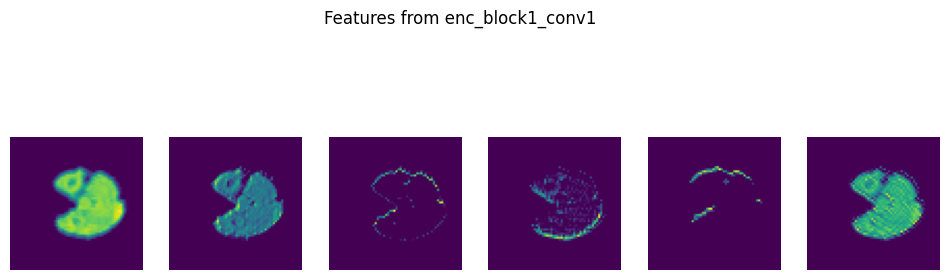

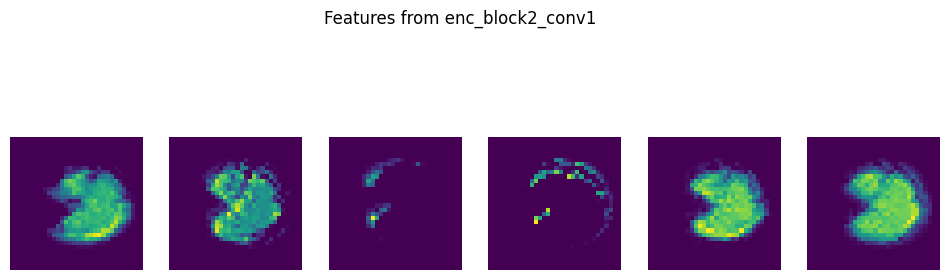

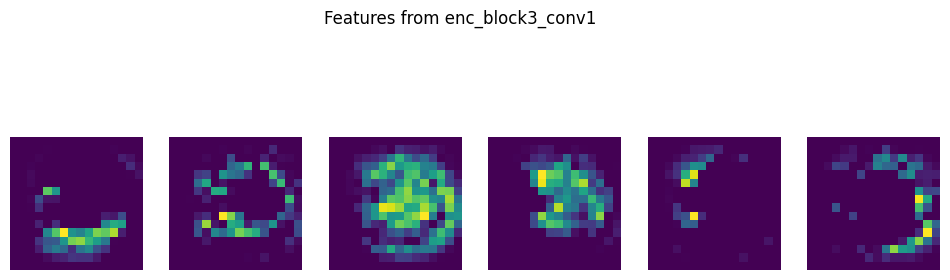

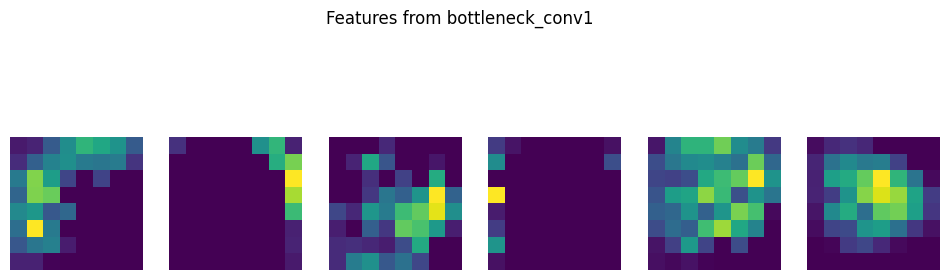

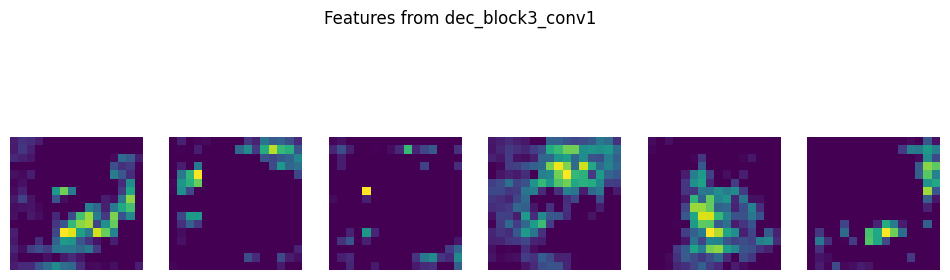

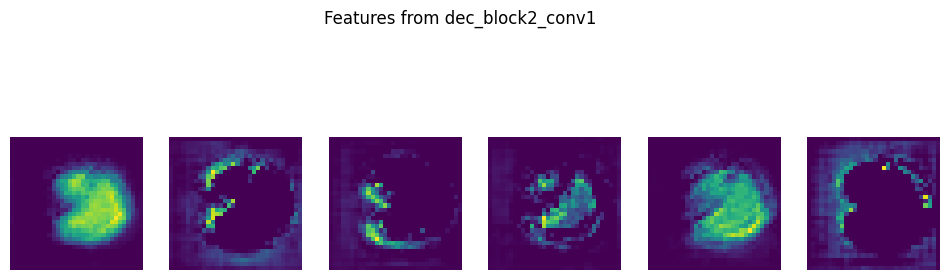

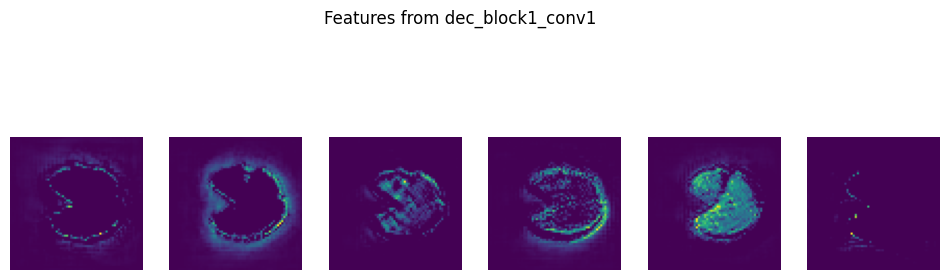

In [20]:
for fmap, name in zip(feature_maps, layer_names):
    num_channels = fmap.shape[-1]
    size = fmap.shape[1]

    # Show first 6 channels
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Features from {name}")

    for i in range(min(6, num_channels)):
        plt.subplot(1, 6, i+1)
        plt.imshow(fmap[0, :, :, i], cmap="viridis")
        plt.axis("off")

    plt.show()
